# Week 6 — Graph-RAG over Your Corpus
**Goal:** Build an entity graph from your corpus and retrieve evidence using neighborhood expansion.

**Colab tips:** You can run this notebook in Colab. If using your own PDFs, mount Drive.


In [2]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.9 MB/s eta 0:00:00


In [3]:

#@title Setup (Colab-friendly)
import os, re, json, math, time, random
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
from typing import List, Dict, Tuple
import glob
import PyPDF2


def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text() + "\\n"
    return text

# Load your documents
pdf_files = glob.glob("/content/data_week6/Complete home repair  with 350 projects and 2300 photos.pdf")
texts = []
doc_ids = []

for i, pdf_file in enumerate(pdf_files):
    text = extract_text_from_pdf(pdf_file)
    texts.append(text)
    doc_ids.append(f"doc{i+1}")

corpus = pd.DataFrame({"doc_id": doc_ids, "text": texts})
corpus.to_csv(corpus_path, index=False)

'''
DATA_DIR = "./data_week6"
os.makedirs(DATA_DIR, exist_ok=True)

corpus_path = os.path.join(DATA_DIR, "corpus.csv")
if not os.path.exists(corpus_path):
    demo = pd.DataFrame({
        "doc_id": [f"doc{i}" for i in range(1,6)],
        "text": [
            "Method X was introduced by Author A and compared on Dataset D1 with F1=0.78.",
            "Author A collaborated with Author B; Method X improved Metric F1 on D1.",
            "Dataset D2 was used to evaluate Method Y introduced by Author C.",
            "Paper P3 applies Method X to Dataset D2 and reports Accuracy 0.82.",
            "Survey S1 links Method Y, Dataset D2, and Metric AUC."
        ]
    })
    demo.to_csv(corpus_path, index=False)
corpus = pd.read_csv(corpus_path)
corpus.head()
'''


NameError: name 'corpus_path' is not defined

## 1. Lightweight Entity Extraction

In [ ]:
# Replace the ENTITY_PATTERNS in Section 1 with these home repair patterns:
ENTITY_PATTERNS = {
    "TOOL": r"\b(hammer|screwdriver|drill|wrench|pliers|saw|level|tape measure|utility knife)\b",
    "MATERIAL": r"\b(wood|drywall|paint|nails|screws|lumber|plywood|insulation|caulk)\b",
    "PROBLEM": r"\b(leak|crack|hole|damage|clog|break|rust|rot|stain)\b",
    "LOCATION": r"\b(kitchen|bathroom|bedroom|basement|attic|roof|wall|floor|ceiling|pipe|faucet)\b",
    "TECHNIQUE": r"\b(measuring|cutting|sanding|painting|fastening|sealing|insulating|framing)\b"
}

import spacy
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2000000 # Increase max_length to handle longer texts

def extract_entities_spacy(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ in ["PERSON", "ORG", "PRODUCT", "WORK_OF_ART"]:
            entities.append((ent.text, ent.label_, ent.start_char, ent.end_char))
    return entities

rows = []
for _, r in corpus.iterrows():
    ents = extract_entities_spacy(r["text"])
    for e, typ, s, t in ents:
        rows.append({"doc_id": r["doc_id"], "entity": e, "type": typ, "start": s, "end": t, "span": r["text"][max(0,s-40):min(len(r['text']),t+40)]})
ents_df = pd.DataFrame(rows)
ents_df.head(10)

,doc_id,entity,type,start,end,span
0,doc1,MAIN,ORG,62,66,.. .. - _ DAVENPORT PUBLIC LIBRARY \n32^ MAIN ...
1,doc1,Tim Himsel,PERSON,213,223,vepub.com \nCredits \nCreative Director: Tim H...
2,doc1,Bryan Trandem,PERSON,243,256,Director: Tim Himsel \nExecutive Editor: Bryan...
3,doc1,Jerri Farris,PERSON,278,290,tor: Bryan Trandem \nEditorial Director: Jerri...
4,doc1,Michelle Skudlarek \nAssisting Project Managers,PERSON,309,355,irector: Jerri Farris \nManaging Editor: Miche...
5,doc1,Jeanette Moss McCurdy,PERSON,357,378,Skudlarek \nAssisting Project Managers: Jeane...
6,doc1,Tracy Stanley,PERSON,380,393,"roject Managers: Jeanette Moss McCurdy, Tracy ..."
7,doc1,Thomas G. Lemmer,PERSON,408,424,"ss McCurdy, Tracy Stanley \nLead Editor: Thoma..."
8,doc1,Brett Martin,PERSON,435,447,Lead Editor: Thomas G. Lemmer \nEditors: Brett...
9,doc1,Karen Ruth \nTechnical,PERSON,449,470,"homas G. Lemmer \nEditors: Brett Martin, Karen..."


## 2. Relation Extraction (Co-occurrence within sentence)

In [ ]:

def sentence_split(text):
    import re
    return re.split(r"(?<=[.!?])\s+", text)

edges = []
for _, r in corpus.iterrows():
    for sent in sentence_split(r["text"]):
        ents = extract_entities_spacy(sent)
        for i in range(len(ents)):
            for j in range(i+1, len(ents)):
                e1, t1, *_ = ents[i]
                e2, t2, *_ = ents[j]
                edges.append({"doc_id": r["doc_id"], "head": e1, "type1": t1, "tail": e2, "type2": t2, "sentence": sent})

edges_df = pd.DataFrame(edges)
edges_df.head(10)


,doc_id,head,type1,tail,type2,sentence
0,doc1,MAIN,ORG,Tim Himsel,PERSON,- _ DAVENPORT PUBLIC LIBRARY \n32^ MAIN STREET...
1,doc1,MAIN,ORG,Bryan Trandem,PERSON,- _ DAVENPORT PUBLIC LIBRARY \n32^ MAIN STREET...
2,doc1,MAIN,ORG,Jerri Farris,PERSON,- _ DAVENPORT PUBLIC LIBRARY \n32^ MAIN STREET...
3,doc1,MAIN,ORG,Michelle Skudlarek \nAssisting Project Managers,PERSON,- _ DAVENPORT PUBLIC LIBRARY \n32^ MAIN STREET...
4,doc1,MAIN,ORG,Jeanette Moss McCurdy,PERSON,- _ DAVENPORT PUBLIC LIBRARY \n32^ MAIN STREET...
5,doc1,MAIN,ORG,Tracy Stanley,PERSON,- _ DAVENPORT PUBLIC LIBRARY \n32^ MAIN STREET...
6,doc1,MAIN,ORG,Thomas G.,PERSON,- _ DAVENPORT PUBLIC LIBRARY \n32^ MAIN STREET...
7,doc1,Tim Himsel,PERSON,Bryan Trandem,PERSON,- _ DAVENPORT PUBLIC LIBRARY \n32^ MAIN STREET...
8,doc1,Tim Himsel,PERSON,Jerri Farris,PERSON,- _ DAVENPORT PUBLIC LIBRARY \n32^ MAIN STREET...
9,doc1,Tim Himsel,PERSON,Michelle Skudlarek \nAssisting Project Managers,PERSON,- _ DAVENPORT PUBLIC LIBRARY \n32^ MAIN STREET...


## 3. Build Graph (NetworkX) and Attach Evidence

In [ ]:

G = nx.Graph()
for _, e in ents_df.iterrows():
    G.add_node(e["entity"], type=e["type"])

for _, ed in edges_df.iterrows():
    G.add_edge(ed["head"], ed["tail"], doc_id=ed["doc_id"], sentence=ed["sentence"])

len(G.nodes()), len(G.edges())


(1424, 3880)

## 4. Graph-aware Retrieval

In [ ]:

def detect_seed_entities(query: str):
    seeds = []
    for node in G.nodes():
        if node.lower().split()[-1] in query.lower():
            seeds.append(node)
    for node, data in G.nodes(data=True):
        if data.get("type") in ("METHOD","DATASET") and data["type"].lower() in query.lower():
            seeds.append(node)
    return list(dict.fromkeys(seeds))

def neighborhood_evidence(seeds, hops=1, max_spans=12):
    spans = []
    seen_edges = set()
    for s in seeds:
        nodes = nx.single_source_shortest_path_length(G, s, cutoff=hops).keys()
        for u in nodes:
            for v in G.neighbors(u):
                e = tuple(sorted([u, v]))
                if e in seen_edges:
                    continue
                seen_edges.add(e)
                data = G.get_edge_data(u, v)
                spans.append({"u": u, "v": v, "doc_id": data.get("doc_id"), "sentence": data.get("sentence")})
                if len(spans) >= max_spans:
                    return spans
    return spans

def graph_rag(query: str, hops=1):
    seeds = detect_seed_entities(query)
    spans = neighborhood_evidence(seeds, hops=hops)
    return {"seeds": seeds, "spans": spans}

demo_out = graph_rag("Methods for unclogging drains")
demo_out



{'seeds': ['Fixture Drains',
  'F',
  'Dressing for the Job \nA',
  'Replacing a Broken Tread \nA',
  'U',
  'Drain',
  'Types M',
  'K. Type M',
  'Types L',
  'Type L',
  'Type M',
  '302 S',
  'Floor Drains',
  'Clogged Tub Drains',
  'Tub Drain',
  '326 S',
  'air rush¬ \ning',
  '340 S',
  'Straightening Fins & Clearing Drains',
  'Create L',
  'Security, Safety & Health U p g',
  'C to H',
  'Boiler Drain',
  '444 S y s'],
 'spans': [{'u': 'Fixture Drains',
   'v': 'Applying Paint & Primer',
   'doc_id': 'doc1',
   'sentence': 'Applying Paint & Primer .240 \nConcrete & Asphalt.248 \nPatching Holes.252 \nRepairing Walkways.254 \nRepairing Concrete Steps .258 \nReplacing Concrete Steps.260 \nRepairing Vertical Surfaces .264 \nRepairing Asphalt.266 \\nPlumbing .272 \nPipe & Fittings.278 \nWorking with Plastic Pipe .280 \nWorking with Copper Pipe .284 \nUsing Compression Fittings .290 \nUsing Flare Fittings.292 \nWorking with Galvanized Iron Pipe .294 \nWorking with Cast-iron Pipe.29

## 5. Prompt Assembly (stub)

In [ ]:

def assemble_prompt(query, seeds, spans):
    ev_lines = [f"- ({s['doc_id']}) {s['sentence']}" for s in spans]
    return f"""System: Answer using ONLY the evidence and cite (doc_id).
Query: {query}

Seeds: {', '.join(seeds)}

Evidence:\n""" + "\n".join(ev_lines) + "\n\nAnswer:"

print(assemble_prompt("Which dataset evaluated Method X with F1?", demo_out["seeds"], demo_out["spans"]))


System: Answer using ONLY the evidence and cite (doc_id).
Query: Which dataset evaluated Method X with F1?

Seeds: Fixture Drains, F, Dressing for the Job 
A, Replacing a Broken Tread 
A, U, Drain, Types M, K. Type M, Types L, Type L, Type M, 302 S, Floor Drains, Clogged Tub Drains, Tub Drain, 326 S, air rush¬ 
ing, 340 S, Straightening Fins & Clearing Drains, Create L, Security, Safety & Health U p g, C to H, Boiler Drain, 444 S y s

Evidence:
- (doc1) Applying Paint & Primer .240 
Concrete & Asphalt.248 
Patching Holes.252 
Repairing Walkways.254 
Repairing Concrete Steps .258 
Replacing Concrete Steps.260 
Repairing Vertical Surfaces .264 
Repairing Asphalt.266 \nPlumbing .272 
Pipe & Fittings.278 
Working with Plastic Pipe .280 
Working with Copper Pipe .284 
Using Compression Fittings .290 
Using Flare Fittings.292 
Working with Galvanized Iron Pipe .294 
Working with Cast-iron Pipe.296 
Valves.300 
Drains, Traps & Vents .304 
Clearing Clogged Tub Drains.308 
Clearing Clogged Sink

## 6. Optional: Graph Visualization

/tmp/ipython-input-333128317.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.title("Entity Graph (demo)"); plt.tight_layout(); plt.show()


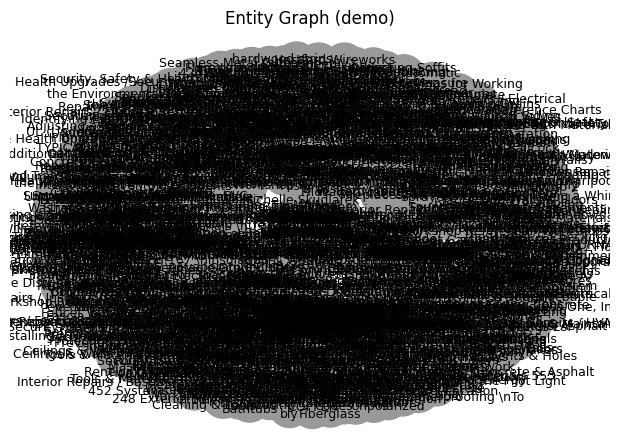

In [ ]:

import matplotlib.pyplot as plt
pos = nx.spring_layout(G, seed=7)
type_to_color = {"METHOD":"#6aa84f","AUTHOR":"#3c78d8","DATASET":"#cc0000","PAPER":"#674ea7","METRIC":"#e69138"}
node_colors = [type_to_color.get(G.nodes[n].get("type",""), "#999") for n in G.nodes()]
plt.figure(figsize=(6,4))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=900, font_size=9, edge_color="#bbb")
plt.title("Entity Graph (demo)"); plt.tight_layout(); plt.show()
